In [1]:
# !pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/Users/raeannechoo/Downloads/fraud.csv")

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

X = X.drop(columns=['PolicyNumber'])

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

pipeline = ImbPipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [6]:
# 2. BASELINE MODEL WITH CROSS-VALIDATION (SMOTEENN AT EACH FOLD)

print("\nTRAINING BASELINE DECISION TREE WITH SMOTEENN AT EACH FOLD")

# Set baseline parameters
baseline_pipeline = ImbPipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        min_impurity_decrease=0.001
    ))
])

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with SMOTEENN applied at each fold
cv_results_baseline = cross_validate(
    baseline_pipeline,
    X_train,
    y_train,
    cv= cv,
    scoring=scoring_metrics,
    return_train_score=True,
    verbose=1
)


TRAINING BASELINE DECISION TREE WITH SMOTEENN AT EACH FOLD


In [7]:
print(pd.DataFrame(cv_results_baseline))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0  1.507512    0.027233       0.736359        0.768275        0.122244   
1  1.222387    0.023734       0.729876        0.756790        0.132325   
2  1.347574    0.029251       0.756757        0.757498        0.147303   
3  1.919917    0.019001       0.765946        0.785328        0.151515   
4  2.016768    0.053275       0.729189        0.761821        0.125000   

   train_precision  test_recall  train_recall   test_f1  train_f1  \
0         0.170124     0.549550      0.740406  0.200000  0.276677   
1         0.161933     0.630631      0.733634  0.218750  0.265306   
2         0.155533     0.645455      0.686937  0.239865  0.253638   
3         0.167247     0.630631      0.650113  0.244328  0.266051   
4         0.167003     0.585586      0.747178  0.206022  0.272990   

   test_roc_auc  train_roc_auc  
0      0.750391       0.832637  
1      0.785736       0.821079  
2      0.809545       0.820451  
3      0

In [8]:
# 3. HYPERPARAMETER TUNING WITH GRID SEARCH

param_grid_optimized = {
    'classifier__max_depth': [10, 15, 20, None],  
    'classifier__min_samples_split': [10, 20, 50],  
    'classifier__min_samples_leaf': [5, 10, 20],  
    'classifier__min_impurity_decrease': [0.001, 0.01],  
    'classifier__criterion': ['gini'],  
    'classifier__max_features': ['sqrt', None]  
}

# Create the full pipeline for grid search
grid_pipeline = ImbPipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_grid = GridSearchCV(
    grid_pipeline,
    param_grid_optimized,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

dt_grid.fit(X_train, y_train)

print("\nBest Parameters Found:")
for param, value in dt_grid.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation F1-Score:", dt_grid.best_score_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=5, classifier__min_samples_split=10; total time=   2.6s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=5, classifier__min_samples_split=10; total time=   2.7s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=5, classifier__min_samples_split=10; total time=   2.7s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=5, classifier__min_samples_split=20; total time=   2.7s
[CV] END classifier__criterion=gini, classifier__max_dept

In [9]:
# 4. EVALUATE BEST MODEL ON HELD-OUT TEST SET

# Get the best model (entire pipeline)
best_pipeline = dt_grid.best_estimator_

# Get probability predictions
y_pred_proba_test = best_pipeline.predict_proba(X_val)[:, 1]

# Calculate precision and recall at different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_test)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Find threshold that maximizes F1
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print("Optimal Threshold", optimal_threshold)
print(f"Precision:", precisions[optimal_idx])
print(f"Recall:", [optimal_idx])
print(f"F1-Score:", f1_scores[optimal_idx])

Optimal Threshold 0.7720797720797721
Precision: 0.16808149405772496
Recall: [np.int64(25)]
F1-Score: 0.2561448900025351


In [10]:
print(optimal_threshold)

0.7720797720797721


In [11]:
# Make predictions with optimal threshold
y_pred_test = (y_pred_proba_test >= optimal_threshold).astype(int)

# Evaluate on test set
print("\nOptimized Model Performance (using threshold =", round(optimal_threshold, 3), "):")
print("Accuracy:", round(accuracy_score(y_val, y_pred_test), 4))
print("Precision:", round(precision_score(y_val, y_pred_test), 4))
print("Recall:", round(recall_score(y_val, y_pred_test), 4))
print("F1-Score:", round(f1_score(y_val, y_pred_test), 4))
print("ROC-AUC Score:", round(roc_auc_score(y_val, y_pred_proba_test), 4))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_test))


Optimized Model Performance (using threshold = 0.772 ):
Accuracy: 0.8136
Precision: 0.1681
Recall: 0.538
F1-Score: 0.2561
ROC-AUC Score: 0.8036

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2900
           1       0.17      0.54      0.26       184

    accuracy                           0.81      3084
   macro avg       0.57      0.68      0.57      3084
weighted avg       0.92      0.81      0.86      3084



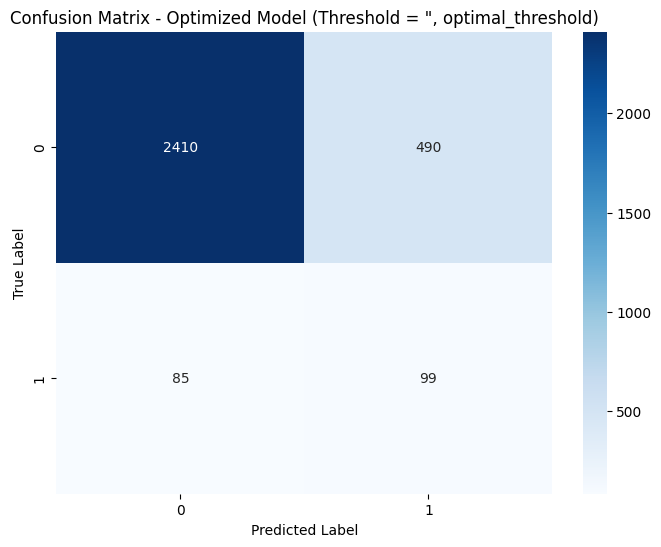

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Optimized Model (Threshold = ", optimal_threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# 5. DETAILED CROSS-VALIDATION RESULTS FOR BEST MODEL

cv_results_optimized = cross_validate(
    best_pipeline,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring_metrics,
    return_train_score=True
)

In [14]:
print(pd.DataFrame(cv_results_optimized))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0  1.052435    0.017929       0.737979        0.773544        0.122984   
1  1.026880    0.017132       0.735818        0.764762        0.133721   
2  0.980862    0.018259       0.760000        0.760875        0.149160   
3  1.066380    0.017699       0.775135        0.799243        0.151030   
4  0.998495    0.016967       0.738378        0.770197        0.126253   

   train_precision  test_recall  train_recall   test_f1  train_f1  \
0         0.172597     0.549550      0.733634  0.200988  0.279450   
1         0.166495     0.621622      0.731377  0.220096  0.271243   
2         0.157895     0.645455      0.689189  0.242321  0.256927   
3         0.176689     0.594595      0.643341  0.240876  0.277237   
4         0.170681     0.567568      0.735892  0.206557  0.277093   

   test_roc_auc  train_roc_auc  
0      0.748421       0.834812  
1      0.783194       0.824107  
2      0.809700       0.822036  
3      0

FEATURE IMPORTANCE ANALYSIS


<Figure size 1000x800 with 0 Axes>

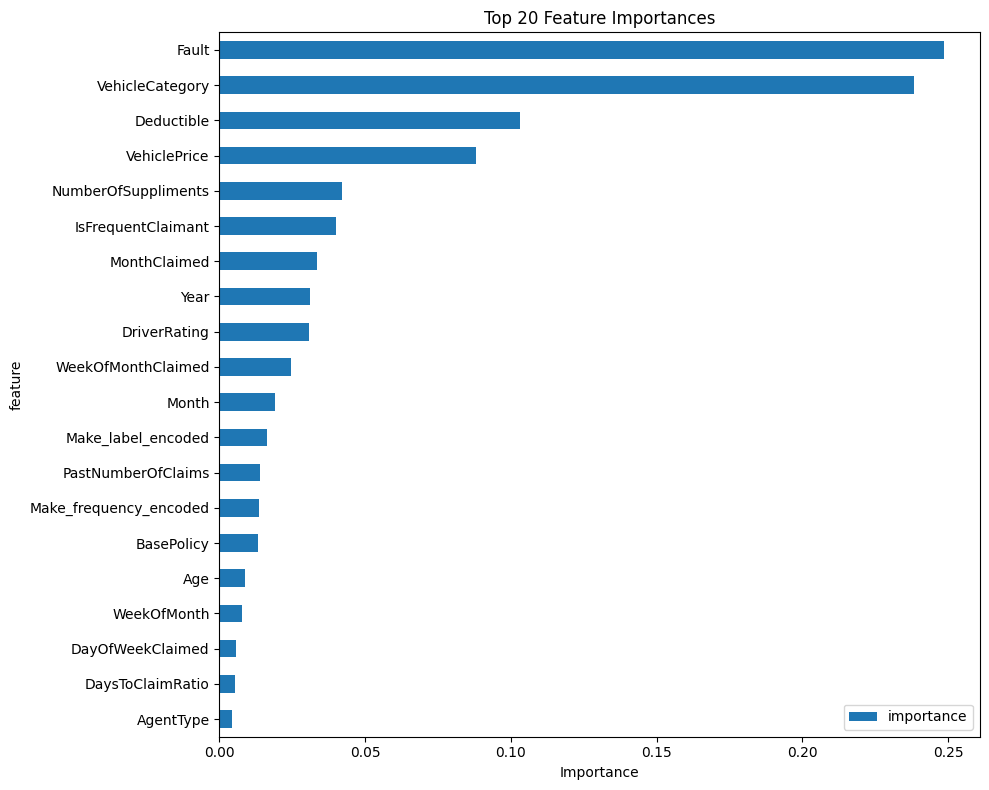

In [15]:
# 6. FEATURE IMPORTANCE ANALYSIS

print("FEATURE IMPORTANCE ANALYSIS")

# Access the classifier from the best pipeline
best_classifier = best_pipeline.named_steps['classifier']

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importance.head(20).plot(x='feature', y='importance', kind='barh', figsize=(10, 8))
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
print("\nMODEL SUMMARY")

print("Tree Depth:", best_classifier.get_depth())
print("Number of Leaves:", best_classifier.get_n_leaves())
print("Number of Features Used:", np.sum(best_classifier.feature_importances_ > 0))
print("Performance with optimal threshold (" + str(round(optimal_threshold, 3)) + "):")
print("Test F1-Score:", round(f1_score(y_val, y_pred_test, average='weighted', zero_division=0), 4))
print("Test ROC-AUC:", round(roc_auc_score(y_val, y_pred_proba_test), 4))
print("CV F1-Score:", round(cv_results_optimized['test_f1'].mean(), 4), "(+/-", str(round(cv_results_optimized['test_f1'].std() * 2, 4)) + ")")


MODEL SUMMARY
Tree Depth: 11
Number of Leaves: 41
Number of Features Used: 23
Performance with optimal threshold (0.772):
Test F1-Score: 0.8554
Test ROC-AUC: 0.8036
CV F1-Score: 0.2222 (+/- 0.0341)
